#### <b>Prepare Source Codes</b>

* Reference: https://github.com/genforce/interfacegan

In [1]:
!git clone https://github.com/ndb796/interfacegan
%cd interfacegan

Cloning into 'interfacegan'...
remote: Enumerating objects: 247, done.
remote: Total 247 (delta 0), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (247/247), 11.39 MiB | 29.52 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/content/interfacegan


#### <b>Prepare the Pre-trained StyleGAN Model</b>

* Reference: https://github.com/NVlabs/stylegan
* Load PyTorch model weights.

In [2]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EUGr2B_vVStNmoL8_Dr9bjEB3R71fqmw7GU1oqLVg_YNnA?download=1 -O ./models/pretrain/stylegan_celebahq.pth

--2021-03-14 08:30:08--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EUGr2B_vVStNmoL8_Dr9bjEB3R71fqmw7GU1oqLVg_YNnA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/StyleGAN/stylegan_celebahq.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVUdyMkJfdlZTdE5tb0w4X0RyOWJqRUIzUjcxZnFtdzdHVTFvcUxWZ19ZTm5BP3J0aW1lPXo3N1RZTVBtMkVn [following]
--2021-03-14 08:30:09--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/StyleGAN/stylegan_celebahq.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVUdyMkJfd

In [ ]:
from models.model_settings import MODEL_POOL

print(list(MODEL_POOL))

['pggan_celebahq', 'stylegan_celebahq', 'stylegan_ffhq']


#### <b>Define Model Architecture</b>

In [3]:
import torch
from torchvision import transforms
from torchvision.models import resnet18

from PIL import Image
from glob import glob
import numpy as np


class ImageToLatent(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = list(resnet18(pretrained=True).children())[:-2]
        self.resnet = torch.nn.Sequential(*self.resnet)
        self.conv2d = torch.nn.Conv2d(512, 128, kernel_size=1)
        self.flatten = torch.nn.Flatten()
        self.dense = torch.nn.Linear(8192, 512)

    def forward(self, image):
        x = self.resnet(image)
        x = self.conv2d(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = x.view((-1, 512))

        return x

#### <b>Load the Encoder Model</b>

In [4]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYdsgLq3jvxBunnKEhl9evcBW6CB7nintdGIjfe-Ye8GOA?download=1 -O pytorch_celebahq_encoder_truncation_80.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcoReXUVkLZOolREBNIEl_cBb6Vniw_L6Kfod-G26GZEcA?download=1 -O pytorch_celebahq_encoder_truncation_90.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERtQPwcbKk5DpU2xo5uSb4IBSoqLray95YdPqBstE_TQwg?download=1 -O pytorch_celebahq_encoder_truncation_100.pth

--2021-03-14 08:31:11--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYdsgLq3jvxBunnKEhl9evcBW6CB7nintdGIjfe-Ye8GOA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/InterFaceGAN/pytorch_celebahq_encoder_truncation_80.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWWRzZ0xxM2p2eEJ1bm5LRWhsOWV2Y0JXNkNCN25pbnRkR0lqZmUtWWU4R09BP3J0aW1lPWJmVlZoc1BtMkVn [following]
--2021-03-14 08:31:12--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/InterFaceGAN/pytorch_celebahq_encoder_truncation_80.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJ

In [5]:
regressor1 = ImageToLatent().cuda()
regressor1.load_state_dict(torch.load("pytorch_celebahq_encoder_truncation_80.pth"))
regressor1.eval()

regressor2 = ImageToLatent().cuda()
regressor2.load_state_dict(torch.load("pytorch_celebahq_encoder_truncation_90.pth"))
regressor2.eval()

regressor3 = ImageToLatent().cuda()
regressor3.load_state_dict(torch.load("pytorch_celebahq_encoder_truncation_100.pth"))
regressor3.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ImageToLatent(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

#### <b>Test the Model</b>

In [6]:
from models.stylegan_generator import StyleGANGenerator


def normalized_to_normal_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 3, 1, 1).float()
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 3, 1, 1).float()
    
    image = image.detach().cpu()
    image *= std
    image += mean
    image *= 255
    
    image = image.numpy()
    image = np.transpose(image, (0, 2, 3, 1))

    return image.astype(np.uint8)


class PostSynthesisProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.min_value = -1
        self.max_value = 1

    def forward(self, synthesized_image):
        synthesized_image = (synthesized_image - self.min_value) * torch.tensor(255).float() / (self.max_value - self.min_value)
        synthesized_image = torch.clamp(synthesized_image + 0.5, min=0, max=255)

        return synthesized_image


synthesizer = StyleGANGenerator("stylegan_celebahq").model.synthesis
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)

[2021-03-14 08:34:17,374][INFO] Loading pytorch model from `models/pretrain/stylegan_celebahq.pth`.
[2021-03-14 08:34:17,683][INFO] Successfully loaded!
[2021-03-14 08:34:17,684][INFO]   `lod` of the loaded model is 0.0.


### <b>CelebA Dataset Download</b>

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

In [7]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcWlrJ2qjtRJtQVIwR1kW2EBTj8le3PdXI4TYsKErsGMcA?download=1 -O CelebA_HQ_facial_identity_dataset_test.zip
!unzip CelebA_HQ_facial_identity_dataset_test.zip -d ./CelebA_HQ_facial_identity_dataset_test

In [9]:
from torchvision import datasets, models, transforms
import os

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
resizer = transforms.Compose([
    transforms.Resize((224, 224))
])
normalizer = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = './CelebA_HQ_facial_identity_dataset_test/'

test_dataset = datasets.ImageFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', 

In [10]:
# Get normal images
num_test_images = 5
images = torch.cat([test_dataset[i][0].unsqueeze(0).cuda() for i in range(num_test_images)], dim=0)
images = normalizer(images)
normal_images = normalized_to_normal_image(images)
print(normal_images.shape)

# Get predicted latents
pred_dlatents = regressor1(images).view(num_test_images, 1, 512)
pred_dlatents = pred_dlatents.expand(num_test_images, 18, 512)
print(pred_dlatents.shape)

# Get predicted images
pred_images = synthesizer(pred_dlatents)
pred_images = post_process(pred_images)
pred_images = np.transpose(pred_images, (0, 2, 3, 1))
print(pred_images.shape)

(5, 256, 256, 3)
torch.Size([5, 18, 512])
(5, 1024, 1024, 3)


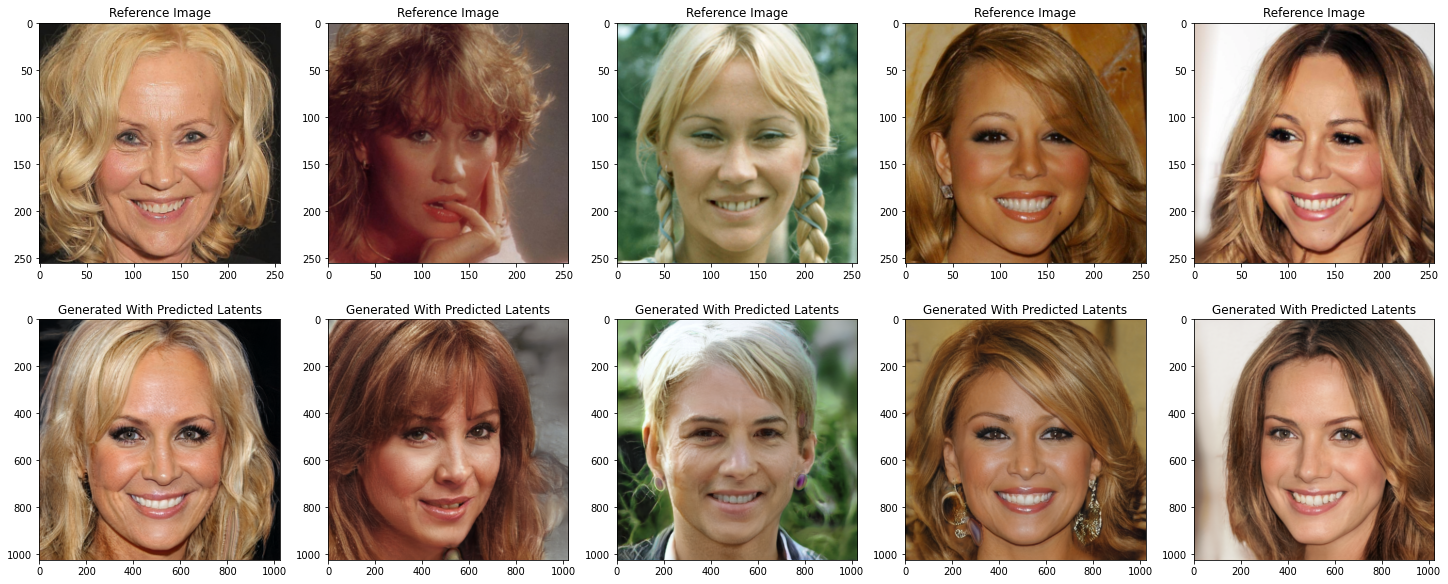

In [11]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(25, 10))
columns = len(normal_images)
rows = 2

axis = []

for i in range(columns):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Reference Image")
    plt.imshow(normal_images[i])

for i in range(columns, columns * rows):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Generated With Predicted Latents")
    plt.imshow(pred_images[i - columns])

plt.show()

#### <b>Test the Label Consistency</b>

In [12]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYJeZpups5FEir_wwzkMw30Bq5ZFCA0SbC1UT7ATAwsYsA?download=1 -O facial_identity_classification_transfer_learning_with_ResNet18.pth

--2021-03-14 08:39:42--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYJeZpups5FEir_wwzkMw30Bq5ZFCA0SbC1UT7ATAwsYsA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWUplWnB1cHM1RkVpcl93d3prTXczMEJxNVpGQ0EwU2JDMVVUN0FUQXdzWXNBP3J0aW1lPW9nel90c1RtMkVn [following]
--2021-03-14 08:39:43--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0Z

In [13]:
import torch.nn as nn

save_path = 'facial_identity_classification_transfer_learning_with_ResNet18.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

[Original Image Examples]


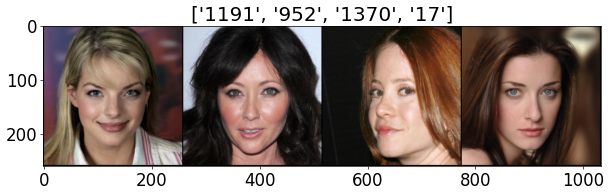

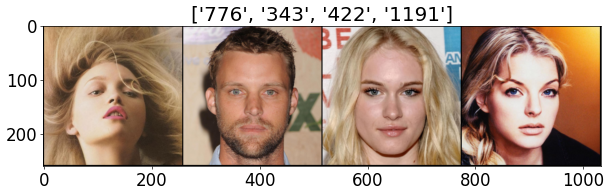

[Original Prediction Result Examples]


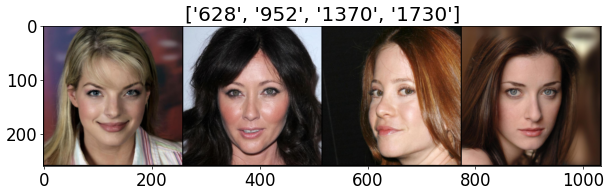

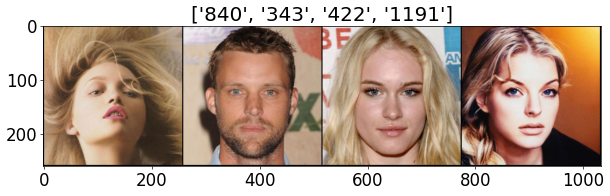

[Encoded Prediction Result Examples]


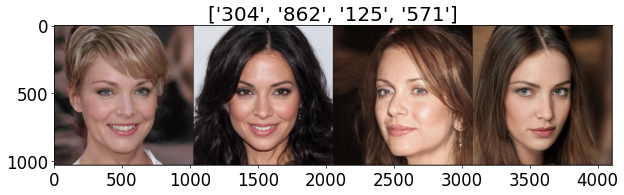

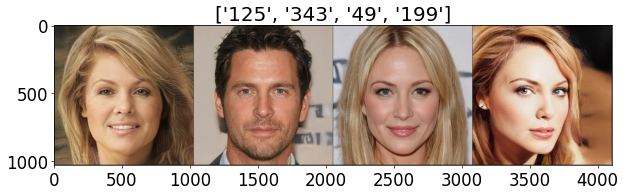

[Test] Original accuracy: 85.9259% Encoded accuracy: 15.3086% Consistency accuracy: 15.9671% Correctly consistency accuracy: 15.0617% Time: 65.6225s


In [20]:
import time
import torchvision

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    ori_running_corrects = 0
    encoded_running_corrects = 0
    consistency = 0
    correctly_consistency = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(normalizer(resizer(inputs)))
        _, ori_preds = torch.max(outputs, 1)

        # Get predicted latents
        pred_dlatents = regressor1(normalizer(inputs)).view(labels.shape[0], 1, 512)
        pred_dlatents = pred_dlatents.expand(labels.shape[0], 18, 512)

        # Get predicted images
        pred_images = synthesizer(pred_dlatents)
        pred_images = post_processing(pred_images) / 255

        outputs = model(normalizer(resizer(pred_images)))
        _, encoded_preds = torch.max(outputs, 1)

        ori_running_corrects += torch.sum(ori_preds == labels.data)
        encoded_running_corrects += torch.sum(encoded_preds == labels.data)
        consistency += torch.sum(ori_preds == encoded_preds)
        correctly_consistency += torch.sum(torch.logical_and(ori_preds == encoded_preds, encoded_preds == labels.data))

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Original Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[4:8]])
            print('[Encoded Prediction Result Examples]')
            images = torchvision.utils.make_grid(pred_images[:4])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[:4]])
            images = torchvision.utils.make_grid(pred_images[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[4:8]])

    ori_epoch_acc = ori_running_corrects / len(test_dataset) * 100.
    encoded_epoch_acc = encoded_running_corrects / len(test_dataset) * 100.
    consistency_epoch_acc = consistency / len(test_dataset) * 100.
    correctly_consistency_epoch_acc = correctly_consistency / len(test_dataset) * 100.

    print('[Test] Original accuracy: {:.4f}% Encoded accuracy: {:.4f}% Consistency accuracy: {:.4f}% Correctly consistency accuracy: {:.4f}% Time: {:.4f}s'.format(ori_epoch_acc, encoded_epoch_acc, consistency_epoch_acc, correctly_consistency_epoch_acc, time.time() - start_time))

[Original Image Examples]


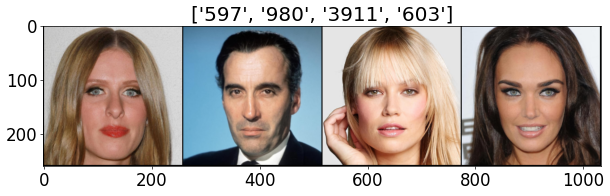

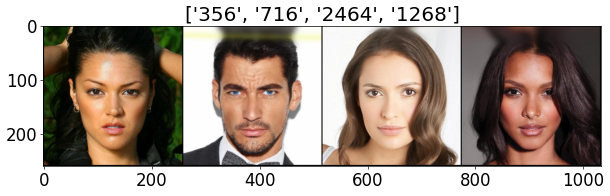

[Original Prediction Result Examples]


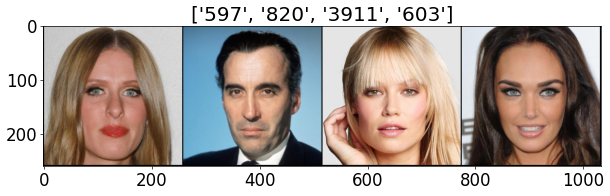

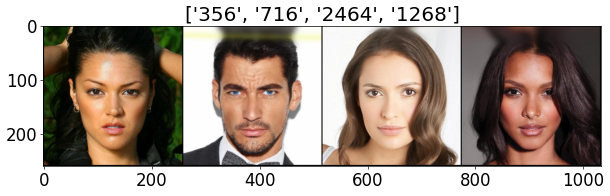

[Encoded Prediction Result Examples]


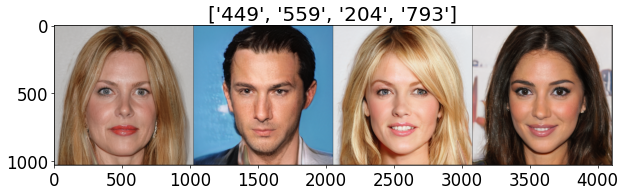

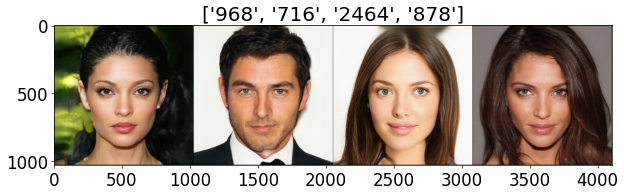

[Test] Original accuracy: 85.9259% Encoded accuracy: 18.5185% Consistency accuracy: 19.7531% Correctly consistency accuracy: 18.2716% Time: 65.4042s


In [21]:
import time
import torchvision

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    ori_running_corrects = 0
    encoded_running_corrects = 0
    consistency = 0
    correctly_consistency = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(normalizer(resizer(inputs)))
        _, ori_preds = torch.max(outputs, 1)

        # Get predicted latents
        pred_dlatents = regressor2(normalizer(inputs)).view(labels.shape[0], 1, 512)
        pred_dlatents = pred_dlatents.expand(labels.shape[0], 18, 512)

        # Get predicted images
        pred_images = synthesizer(pred_dlatents)
        pred_images = post_processing(pred_images) / 255

        outputs = model(normalizer(resizer(pred_images)))
        _, encoded_preds = torch.max(outputs, 1)

        ori_running_corrects += torch.sum(ori_preds == labels.data)
        encoded_running_corrects += torch.sum(encoded_preds == labels.data)
        consistency += torch.sum(ori_preds == encoded_preds)
        correctly_consistency += torch.sum(torch.logical_and(ori_preds == encoded_preds, encoded_preds == labels.data))

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Original Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[4:8]])
            print('[Encoded Prediction Result Examples]')
            images = torchvision.utils.make_grid(pred_images[:4])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[:4]])
            images = torchvision.utils.make_grid(pred_images[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[4:8]])

    ori_epoch_acc = ori_running_corrects / len(test_dataset) * 100.
    encoded_epoch_acc = encoded_running_corrects / len(test_dataset) * 100.
    consistency_epoch_acc = consistency / len(test_dataset) * 100.
    correctly_consistency_epoch_acc = correctly_consistency / len(test_dataset) * 100.

    print('[Test] Original accuracy: {:.4f}% Encoded accuracy: {:.4f}% Consistency accuracy: {:.4f}% Correctly consistency accuracy: {:.4f}% Time: {:.4f}s'.format(ori_epoch_acc, encoded_epoch_acc, consistency_epoch_acc, correctly_consistency_epoch_acc, time.time() - start_time))

[Original Image Examples]


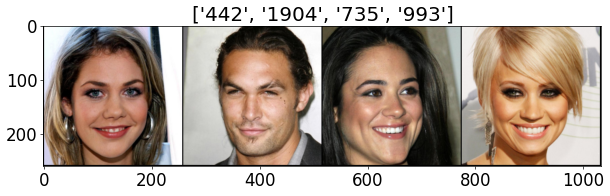

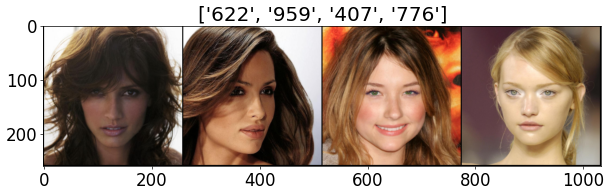

[Original Prediction Result Examples]


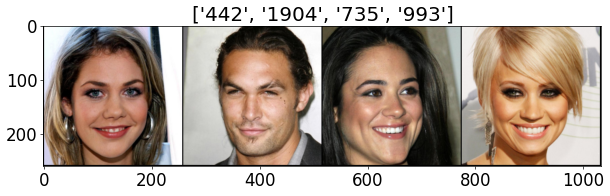

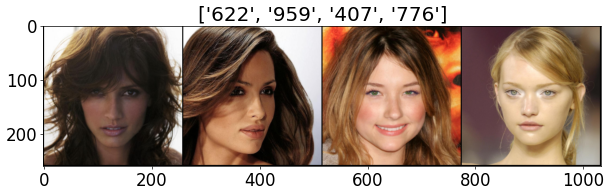

[Encoded Prediction Result Examples]


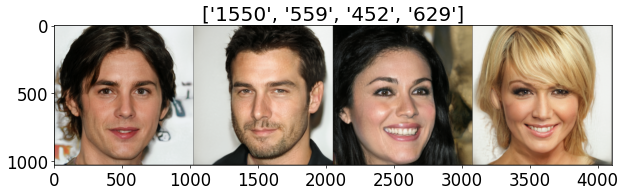

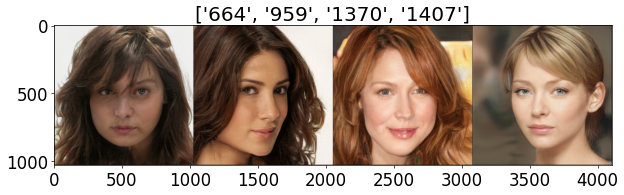

[Test] Original accuracy: 85.9259% Encoded accuracy: 15.9671% Consistency accuracy: 16.7078% Correctly consistency accuracy: 15.7202% Time: 65.6169s


In [22]:
import time
import torchvision

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    ori_running_corrects = 0
    encoded_running_corrects = 0
    consistency = 0
    correctly_consistency = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(normalizer(resizer(inputs)))
        _, ori_preds = torch.max(outputs, 1)

        # Get predicted latents
        pred_dlatents = regressor3(normalizer(inputs)).view(labels.shape[0], 1, 512)
        pred_dlatents = pred_dlatents.expand(labels.shape[0], 18, 512)

        # Get predicted images
        pred_images = synthesizer(pred_dlatents)
        pred_images = post_processing(pred_images) / 255

        outputs = model(normalizer(resizer(pred_images)))
        _, encoded_preds = torch.max(outputs, 1)

        ori_running_corrects += torch.sum(ori_preds == labels.data)
        encoded_running_corrects += torch.sum(encoded_preds == labels.data)
        consistency += torch.sum(ori_preds == encoded_preds)
        correctly_consistency += torch.sum(torch.logical_and(ori_preds == encoded_preds, encoded_preds == labels.data))

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Original Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[4:8]])
            print('[Encoded Prediction Result Examples]')
            images = torchvision.utils.make_grid(pred_images[:4])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[:4]])
            images = torchvision.utils.make_grid(pred_images[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[4:8]])

    ori_epoch_acc = ori_running_corrects / len(test_dataset) * 100.
    encoded_epoch_acc = encoded_running_corrects / len(test_dataset) * 100.
    consistency_epoch_acc = consistency / len(test_dataset) * 100.
    correctly_consistency_epoch_acc = correctly_consistency / len(test_dataset) * 100.

    print('[Test] Original accuracy: {:.4f}% Encoded accuracy: {:.4f}% Consistency accuracy: {:.4f}% Correctly consistency accuracy: {:.4f}% Time: {:.4f}s'.format(ori_epoch_acc, encoded_epoch_acc, consistency_epoch_acc, correctly_consistency_epoch_acc, time.time() - start_time))